<a href="https://colab.research.google.com/github/vneumannufprbr/PracticasTensorflow/blob/main/PredicGenEolLSTMDatosbrutosEspaOkGit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Caso el dataset energy_dataset.csv sea llamado desde el drive del computador o
# del google drive, abilitar las 2 lineas abajo
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
!pip install tensorflow
!pip install keras-tuner
!pip install statsmodels

# Importaciones
import tensorflow as tf
tf.__version__
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.optimizers import SGD, Adam
# incluido por VN
# correlograma y estacionalidad para determinar el tamaño de la ventana (window size)
import statsmodels.api as sm
# Librería para preprocesamiento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import iqr
# Librería para autoajuste de parámetros
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
# Librería pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core import window
from pandas.core import indexes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


/tmp/ipython-input-2-3979348794.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [3]:
# Carga de la base de datos
#df = pd.read_csv("/content/drive/Othercomputers/Meu computador/Google Drive/Especialização IA UFPR/AAA-Curso IA UFPR/Arquitetura de Dados/Artigos de AI aplicada a Sistemas de Energia/ENCONTRO 02/archive/energy_dataset.csv",  low_memory=False) # dtype=dtype_dict,
#!git clone https://github.com/vneumannufprbr/TrabajosRStudio.git # Dataset con 3.000 instancias
#df = pd.read_csv('TrabajosRStudio/energy_dataset.csv',  low_memory=False) # Dataset con 3.000 instancias # dtype=dtype_dict,
!git clone https://github.com/vneumannufprbr/Series-Temporales.git # Dataset con 35.000 instancias
df = pd.read_csv('Series-Temporales/energy_dataset.csv',  low_memory=False) # Dataset con 35.000 instancias # dtype=dtype_dict,dtype_dict = {
dtype_dict = {
    'time': str,
    'generation biomass': float,
    'generation fossil brown coal/lignite': float,
    'generation fossil gas': float,
    'generation fossil hard coal': float,
    'generation fossil oil': float,
    'generation hydro pumped storage consumption': float,
    'generation hydro run-of-river and poundage': float,
    'generation hydro water reservoir': float,
    'generation nuclear': float,
    'generation solar': float,
    'generation waste': float,
    'generation wind onshore': float,
    'forecast solar day ahead': float,
    'forecast wind onshore day ahead': float,
    'total load forecast': float,
    'total load actual': float,
    'price day ahead': float,
     # ... especificar otros tipos de datos de las columnas aquí
    'price actual': float
}
print(df.dtypes)
df

Cloning into 'Series-Temporales'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 15 (delta 3), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 2.88 MiB | 5.65 MiB/s, done.
Resolving deltas: 100% (3/3), done.
time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
g

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [4]:
df.index = pd.to_datetime(df['time'], utc=True)
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

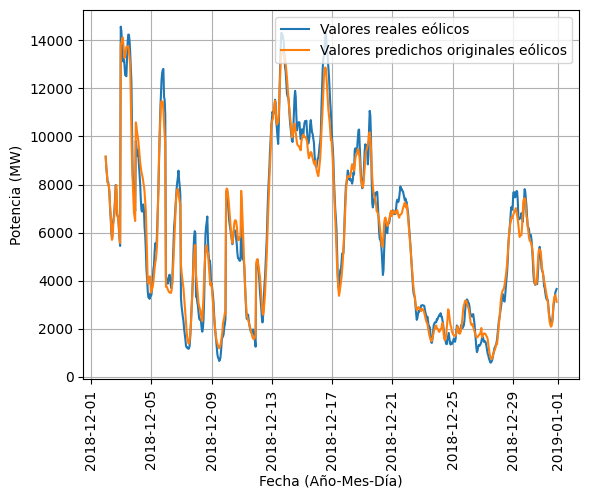

In [5]:
ger_eolica = df['generation wind onshore'] # Cambiado a generación eólica
ger_eolica_predito_origem = df['forecast wind onshore day ahead'] # Cambiado a predicción eólica

plt.plot(ger_eolica[-24*30:], label='Valores reales eólicos')
plt.plot(ger_eolica_predito_origem[-24*30:], label='Valores predichos originales eólicos')
plt.legend()
plt.grid(True)
plt.ylabel('Potencia (MW)')
plt.xlabel('Fecha (Año-Mes-Día)')
plt.xticks(rotation='vertical');

In [6]:
# Preprocesamiento
# incluido por VN

# Calcular el IQR usando la función quantile() de pandas
Q1 = ger_eolica.quantile(0.25)
Q3 = ger_eolica.quantile(0.75)
IQR = Q3 - Q1

# Definir límites superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers
ger_eolica_filt = ger_eolica[(ger_eolica >= lower_bound) & (ger_eolica <= upper_bound)]

# Verificar la cantidad de outliers removidos
outliers_removed = len(ger_eolica) - len(ger_eolica_filt)
print("Outliers removidos:", outliers_removed)
ger_eolica=ger_eolica_filt
series = ger_eolica.values.reshape(-1, 1)
series = series.astype('float64')

# Normalizar los datos de la serie
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)
ger_eolica=pd.Series(series.flatten())

Outliers removidos: 397


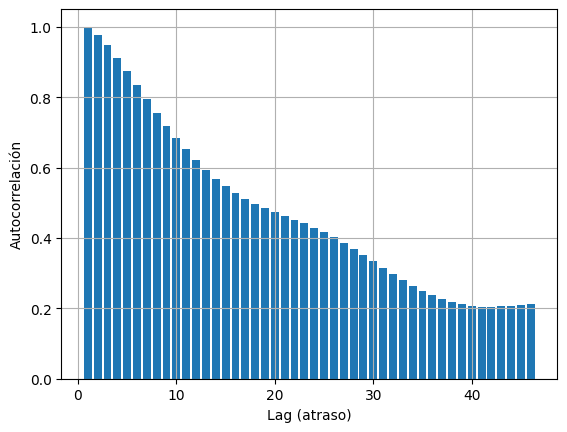

In [7]:
# Correlograma y estacionalidad para determinar el tamaño de la ventana (window size)
# Calcular el correlograma
acf = sm.tsa.acf(ger_eolica)

# Plotar el correlograma
lags = range(1, len(acf)+1)
plt.bar(lags, acf)
plt.xlabel('Lag (atraso)')
plt.ylabel('Autocorrelación')
plt.grid(True)
plt.show()

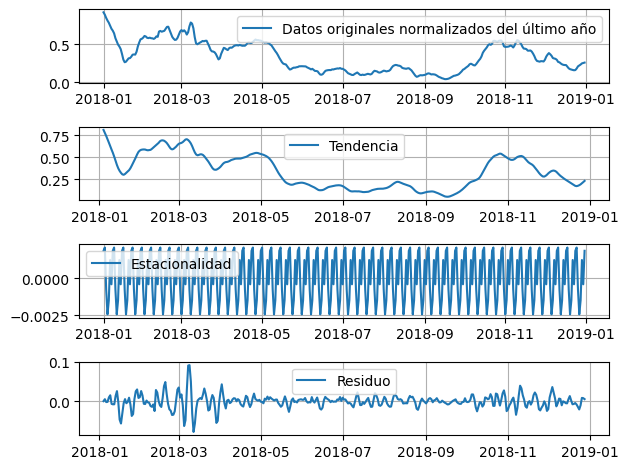

In [8]:
# Definir la serie temporal para identificar la estacionalidad
dates = pd.date_range(start='2018-01-01', periods=365, freq='d')
series2 = pd.Series(ger_eolica.values[-365:], index=dates)

# Convertir el índice a un DatetimeIndex
series2.index = pd.DatetimeIndex(series2.index)

# Descomponer la serie temporal
decomposition = sm.tsa.seasonal_decompose(series2, model='additive')

# Obtener las componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotear las componentes
plt.subplot(411)
plt.grid(True)
plt.plot(series2, label='Datos originales normalizados del último año')
plt.legend(loc='best')
plt.subplot(412)
plt.grid(True)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.grid(True)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.grid(True)
plt.plot(residual, label='Residuo')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
# Tamaño de la ventana sugerido por el correlograma y la estacionalidad: 24h o 168h (ajustar según análisis)
# Mantendremos 168h como ejemplo inicial, pero se puede ajustar.
window_size = 168

def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [10]:
X, y = df_to_X_y(ger_eolica, window_size)
X.shape, y.shape

((34499, 168, 1), (34499,))

In [11]:
X_train, y_train = X[:int(0.8*len(ger_eolica))], y[:int(0.8*len(ger_eolica))]
X_val, y_val  = X[int(0.8*len(ger_eolica)):int(0.9*len(ger_eolica))], y[int(0.8*len(ger_eolica)):int(0.9*len(ger_eolica))]
X_test, y_test = X[int(0.9*len(ger_eolica)):], y[int(0.9*len(ger_eolica)):]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((27733, 168, 1), (27733,), (3467, 168, 1), (3467,), (3299, 168, 1), (3299,))

In [ ]:
# Autoajuste de hiperparámetros
# Definir la función de construcción del modelo
timesteps = window_size
input_dim = 1
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=512, step=64),
                                dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1),
                                input_shape=(timesteps, input_dim)))
    model.add(keras.layers.Dense(units=1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
                  loss='huber')
    return model

# Definir los hiperparámetros a ser ajustados
hp = HyperParameters()
hp.Int('units', min_value=32, max_value=512, step=32)
hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)

# Crear el tuner
tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, hyperparameters=hp)

# Realizar la búsqueda de hiperparámetros
tuner.search(x=X_train, y=y_train, epochs=10, validation_data=(X_val, y_val))

# Obtener el mejor modelo encontrado
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

Trial 2 Complete [00h 43m 42s]
val_loss: 0.00465763732790947

Best val_loss So Far: 0.00465763732790947
Total elapsed time: 00h 56m 08s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
512               |160               |units
0.1               |0.01              |learning_rate
0.4               |0.3               |dropout

Epoch 1/10
867/867 ━━━━━━━━━━━━━━━━━━━━ 1740s 2s/step - loss: nan - val_loss: nan
Epoch 2/10
476/867 ━━━━━━━━━━━━━━━━━━━━ 12:03 2s/step - loss: nan

In [ ]:
from tensorflow.keras.models import clone_model
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Definir una lista de tamaños de lote para probar
batch_sizes_to_try = [16, 32, 64, 128, 256]

best_batch_size = None
best_val_loss = float('inf')
results_batch_tuning = {}

print("Starting batch size tuning...")

for batch_size in batch_sizes_to_try:
    print(f"\nTraining with batch_size: {batch_size}")

    model_for_batch_tuning = clone_model(best_model)
    model_for_batch_tuning.set_weights(best_model.get_weights())

    # Use the best learning rate from the tuner for compiling the model during batch size tuning
    best_learning_rate_tuner = tuner.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')
    model_for_batch_tuning.compile(loss=Huber(), optimizer=Adam(learning_rate=best_learning_rate_tuner), metrics =[RootMeanSquaredError()])

    history = model_for_batch_tuning.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=batch_size,
        verbose=0
    )

    current_val_loss = history.history['val_loss'][-1]
    results_batch_tuning[batch_size] = current_val_loss

    print(f"Validation Loss for batch_size {batch_size}: {current_val_loss:.4f}")

    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        best_batch_size = batch_size

print("\nBatch size tuning finished.")
print(f"Results: {results_batch_tuning}")
print(f"Best batch size: {best_batch_size} with validation loss: {best_val_loss:.4f}")

In [ ]:
best_model.summary()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, LSTM, Dense

# Get the best hyperparameters from the tuner
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

model1 = Sequential()
model1.add(InputLayer((window_size, 1)))
model1.add(LSTM(units=best_hps.get('units'), dropout=best_hps.get('dropout')))
model1.add(Dense(1, 'linear'))

model1.summary()

In [ ]:
# Guarda el mejor modelo para Generación Eólica
cp1= ModelCheckpoint('model_eolica/best_model_eolica.keras', save_best_only=True)
# Use the best learning rate from the tuner
best_learning_rate = tuner.get_best_hyperparameters(num_trials=1)[0].get('learning_rate')
model1.compile(loss=Huber(), optimizer=Adam(learning_rate=best_learning_rate), metrics =[RootMeanSquaredError()])

In [ ]:
tuner.get_best_hyperparameters(num_trials=1)[0].values
r=model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1], batch_size=best_batch_size)

In [ ]:
#Plotar la función de pérdida y RMSE
plt.plot(r.history["loss"], label="Función de pérdida - LSTM")
plt.plot(r.history["val_loss"], label="Val. Función de pérdida de la validación - LSTM")
plt.plot(r.history["root_mean_squared_error"], label="RMSE-LSTM")
plt.plot(r.history["val_root_mean_squared_error"], label="Val. RMSE-LSTM")
plt.legend()
plt.grid(True)
plt.xlabel('Época')
plt.ylabel('Loss/RMSE (valores normalizados)')

In [ ]:
from tensorflow.keras.models import load_model
model1 = load_model('model_eolica/best_model_eolica.keras')

In [ ]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})

# Recuperar valores nominales originales
train_results['Train Predictions'] = scaler.inverse_transform(train_results['Train Predictions'].values.reshape(-1, 1)).flatten()
train_results['Actuals'] = scaler.inverse_transform(train_results['Actuals'].values.reshape(-1, 1)).flatten()

plt.plot(train_results['Train Predictions'][:168], label="Predicho por el entrenamiento")
plt.plot(train_results['Actuals'][:168], label="Valores reales")
plt.legend()
plt.ylabel('Potencia (MW)')
plt.xlabel('Instancia (# hora)')
plt.grid(True)
plt.xticks(rotation='vertical');

In [ ]:
plt.plot(train_results['Train Predictions'][int(0.8*len(ger_eolica))-48:int(0.8*len(ger_eolica))], label="Predicho por el entrenamiento")
plt.plot(train_results['Actuals'][int(0.8*len(ger_eolica))-48:int(0.8*len(ger_eolica))], label="Valores reales")
plt.legend()
plt.ylabel('Potencia (MW)')
plt.xlabel('Instancia (# hora)')
plt.grid(True)
plt.xticks(rotation='vertical');

In [ ]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})

# Recuperar valores nominales originales
val_results['Val Predictions'] = scaler.inverse_transform(val_results['Val Predictions'].values.reshape(-1, 1)).flatten()
val_results['Actuals'] = scaler.inverse_transform(val_results['Actuals'].values.reshape(-1, 1)).flatten()

plt.plot(val_results['Val Predictions'][:48], label="Predicho por la validación")
plt.plot(val_results['Actuals'][:48], label="Valores reales")
plt.legend()
plt.ylabel('Potencia (MW)')
plt.xlabel('Instancia (# hora)')
plt.grid(True)
plt.xticks(rotation='vertical');

In [ ]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})

# Recuperar valores nominales originales
test_results['Test Predictions'] = scaler.inverse_transform(test_results['Test Predictions'].values.reshape(-1, 1)).flatten()
test_results['Actuals'] = scaler.inverse_transform(test_results['Actuals'].values.reshape(-1, 1)).flatten()

In [ ]:
plt.plot(test_results['Test Predictions'][-240:], label="Predicho en los datos de prueba")
plt.plot(test_results['Actuals'][-240:], label="Valores reales")
plt.legend()
plt.ylabel('Potencia (MW)')
plt.xlabel('Instancia (# hora)')
plt.grid(True)
plt.xticks(rotation='vertical');

In [ ]:
# Defina la fecha final de los datos de prueba
data_final_teste = pd.to_datetime('2018-12-31')

from copy import deepcopy

recursive_predictions = []
# Manteniendo la ventana de 720 como ejemplo, ajustar si es necesario
last_window = deepcopy(X_test[-720])
# Ajusta las fechas para la predicción recursiva si es necesario
recursive_dates = pd.date_range(start='2019-01-01', periods=len(last_window) + len(recursive_predictions), freq='h') # Ajustar el rango y la frecuencia según sea necesario

for target_date in recursive_dates:
    next_prediction = model1.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction[0])
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_prediction[0]

# Crear un DataFrame con las predicciones
pred_results = pd.DataFrame({'Date': recursive_dates[:len(recursive_predictions)], 'Predictions': recursive_predictions}) # Ajustar el slice de fechas si es necesario

print(pred_results)

In [ ]:
# Recuperar valores nominales originales
pred_results['Predictions'] = scaler.inverse_transform(pred_results['Predictions'].values.reshape(-1, 1)).flatten()

plt.plot(pred_results['Date'], pred_results['Predictions'], label='Predicción a partir de la última fecha de los datos de prueba') # Actualizar la etiqueta
plt.xlabel('Año-Mes-Día')
plt.xticks(rotation='vertical');
plt.ylabel('Generación Eólica (MW)') # Cambiado a Generación Eólica
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calcular RMSE para los resultados de prueba
rmse_mw = np.sqrt(mean_squared_error(test_results['Actuals'], test_results['Test Predictions']))

print(f"RMSE en MW: {rmse_mw:.2f}")

In [ ]:
from sklearn.metrics import r2_score

# Calcular MSE para los resultados de prueba
mse_mw = mean_squared_error(test_results['Actuals'], test_results['Test Predictions'])

# Calcular R2 para los resultados de prueba
r2 = r2_score(test_results['Actuals'], test_results['Test Predictions'])

print(f"MSE en MW^2: {mse_mw:.2f}")
print(f"R2 score: {r2:.4f}")

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calcular MAE para los resultados de prueba
mae_mw = mean_absolute_error(test_results['Actuals'], test_results['Test Predictions'])

print(f"MAE en MW: {mae_mw:.2f}")